# <center>纸上得来终觉浅，绝知此事要coding</center>
## <center>刘花卷@BNU</center>

# Outline
---
## 1. Build Models
## 2. Simulate and Experiment
## 3. Fit Model to Data
## 4. Parameter Recovery 
## 5. Summary

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sop

# 1. Build Models
1. Goal: to use precise mathematical models to make better sense of behavioral data.
2. Role: The models come in the form of mathematical equations that link the experimentally observable variables to behavior
    - computational models instantiate different ‘algorithmic hypotheses’ about how behavior is generated
3. Descriptive vs Mechanistic
4. Approach
    - heuristics: delta rule
    - AI/CS/MATH: Q-learning, TD-learning
    - Bayes-optimal perspective
5. Why RL

## ⭐Example: Modeling behavior in the multi-armed bandit task
---
<center><img src="bandit.png" style="zoom:100%">
### predict → act/choose → feedback/reward → predict next trial
<!-- ![bandit.png](attachment:bandit.png) -->

In [2]:
def simulate(model,b=0.2,epsilon=0.1,alpha=0.2,beta=1.2,B=0.1,alpha_c=0.1,beta_c=0.1,T=100,k=2,mu=[0.2,0.8]):

    choices=np.zeros(T)
    rewards=np.zeros(T)
    values=np.ones((T,k))/2
    cks=np.ones((T,k))/2
    probs=np.ones((T,k))/2
    
    for t in range(T-1):
        
        # step1: agent make prediction based on obervation
        if model==1:
            probs[t+1]=model1random(b)
        elif model==2:
            probs[t+1]=model2wsls(rewards[t],choices[t],epsilon)
        elif model==3:
            probs[t+1],values[t+1]=model3rw(alpha,beta,choices[t],rewards[t],values[t],B)
        elif model==4:
            probs[t+1],cks[t+1]=model4ck(alpha_c,beta_c,cks[t],choices[t])
        elif model==5:
            probs[t+1],values[t+1],cks[t+1]=model5rw_ck(alpha, beta, alpha_c, beta_c,choices[t],rewards[t],values[t],cks[t])
            
        # step2: agent make action/ choose machine based on probability
        choices[t+1]=choose(probs[t+1])
        
        # step3: environment give feedback to agent based on its choice
        rewards[t+1]=feedback(choices[t+1],mu)

    return probs,choices,rewards

# 1.1 prediction models
---
<center><img src="predict.png" style="zoom:100%"></center>
<!-- ![predict.png](attachment:predict.png) -->

## ⭐Modelling Principles
1. A computational model should be as simple as possible, but no simpler
    - complex model capture more details while simple model generalize better
2. A computational model should be interpretable (as much as possible)
    - negative learning rate is difficult to interpret even if it can improve fits sometimes
3. The models should capture all the hypotheses that you plan to test
    - design models that caputure competing hypotheses
    - better yet, let the data determine which model is the best fit

### <center> Model1: random choice
---
<center><img src="m1.png" style="zoom:100%"></center>
<!-- ![m1.png](attachment:m1.png) -->

In [3]:
def model1random(b):
    prob_arr=np.array([b,1-b])
    return prob_arr

### <center> Model2: win stay lose shift
---
<center><img src="m2.png" style="zoom:100%"></center>
<!-- ![m2.png](attachment:m2.png) -->

In [4]:
def model2wsls(reward_last,choice_last,epsilon):
    choice_last=int(choice_last)
    if reward_last==1:
        prob_arr=[epsilon/2,epsilon/2]
        prob_arr[choice_last]=1-epsilon/2
#         prob_arr[1-choice_last]=epsilon/2
    else:
        prob_arr=[1-epsilon/2,1-epsilon/2]
        prob_arr[choice_last]=epsilon/2
#         prob_arr[1-choice_last]=1-epsilon/2
    return prob_arr

$$ p_t^k=1/2 \ when \ \epsilon=1 $$

### <center> Model3: Rescorla Wagner
---
<center><img src="m3.png" style="zoom:100%"></center>
<!-- ![m3.png](attachment:m3.png) -->

In [5]:
def model3rw(alpha,beta,choice_last,reward_last,value_last,B=0.1):
    # only update last selected one
    value_arr=value_last
    choice_last=int(choice_last)
    value_arr[choice_last]=value_last[choice_last]+alpha*(reward_last-value_last[choice_last])
    prob_arr=np.exp(beta*value_arr)/sum(np.exp(beta*value_arr))
#     prob_left=1/(1+np.exp(beta*(value_arr[1]-value_arr[0]-B)))
#     prob_arr=[prob_left, 1-prob_left]
    return prob_arr,value_arr

$$ Q_{t+1}^{k}=(1-\alpha)Q_{t}^{k}+\alpha r_t $$
$$ p_t^k=1/2 \ when \ \beta=0 $$

### <center> Model4: choice kernel
---
<center><img src="m4.png" style="zoom:100%"></center>
<!-- ![m4.png](attachment:m4.png) -->

In [6]:
def model4ck(alpha_c,beta_c,ck_last,choice_last):
    ck_arr=(1-alpha_c)*ck_last
    choice_last=int(choice_last)
    ck_arr[choice_last]=ck_last[choice_last]+alpha_c*1
    prob_arr=np.exp(beta_c*ck_arr)/sum(np.exp(beta_c*ck_arr))
    return prob_arr,ck_arr

$$ CK_{t+1}^{k}=(1-\alpha_c)CK_{t}^{k}+\alpha_c a_t^k $$
$$ p_t^k=1/2 \ when \ \beta_c=0 $$

### <center> Model5: Rescorla Wagner + choice kernel
---
<center><img src="m5.png" style="zoom:100%"></center>
<!-- ![m5.png](attachment:m5.png) -->

In [7]:
def model5rw_ck(alpha, beta, alpha_c, beta_c,choice_last,reward_last,value_last,ck_last):
    choice_last=int(choice_last)
    value_arr=value_last
    value_arr[choice_last]=value_last[choice_last]+alpha*(reward_last-value_last[choice_last])
    
    ck_arr=(1-alpha_c)*ck_last
    ck_arr[choice_last]=ck_last[choice_last]+alpha_c*1
    
    prob_arr=np.exp(beta*value_arr+beta_c*ck_arr)/sum(np.exp(beta*value_arr+beta_c*ck_arr))
    return prob_arr,value_arr,ck_arr

## 1.2 action model
---
<!-- <center><img src="act.png" style="zoom:100%"></center> -->
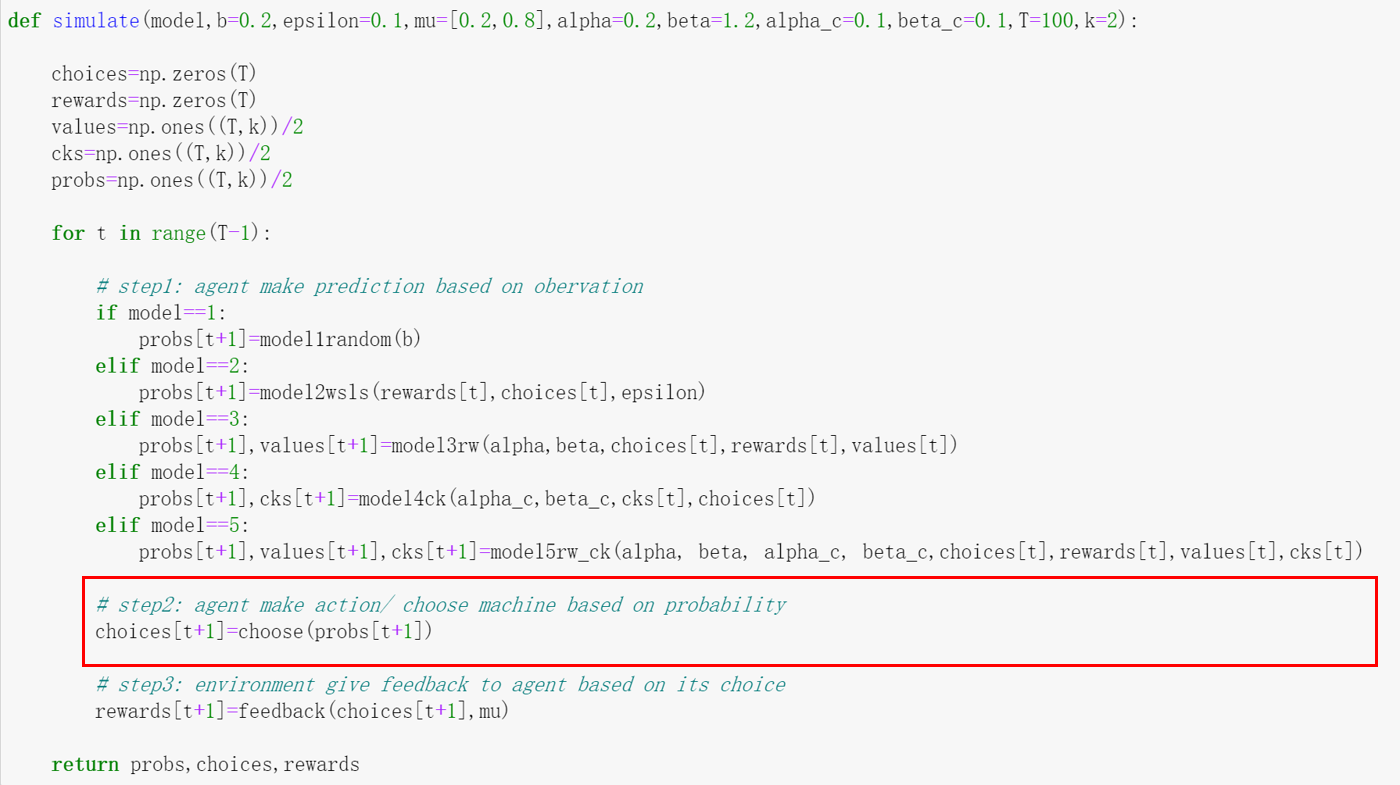

In [8]:
def choose(prob_arr):
    rand=np.random.uniform()
    prob_range=np.append([-1e-5],np.cumsum(prob_arr))
    choice=sum(prob_range<rand)-1
#     print("choice:",choice)
    return int(choice)

<center><img src="choose.png" style="zoom:60%"></center>
<!-- ![choose.png](attachment:choose.png) -->

In [10]:
# test choose function
c=np.zeros(100)
for i in range(100):
    c[i]=choose([0.8,0.2])
sum(c)

17.0

## 1.3 feedback/reward
---
<!-- <center><img src="feedback.png" style="zoom:100%"></center> -->
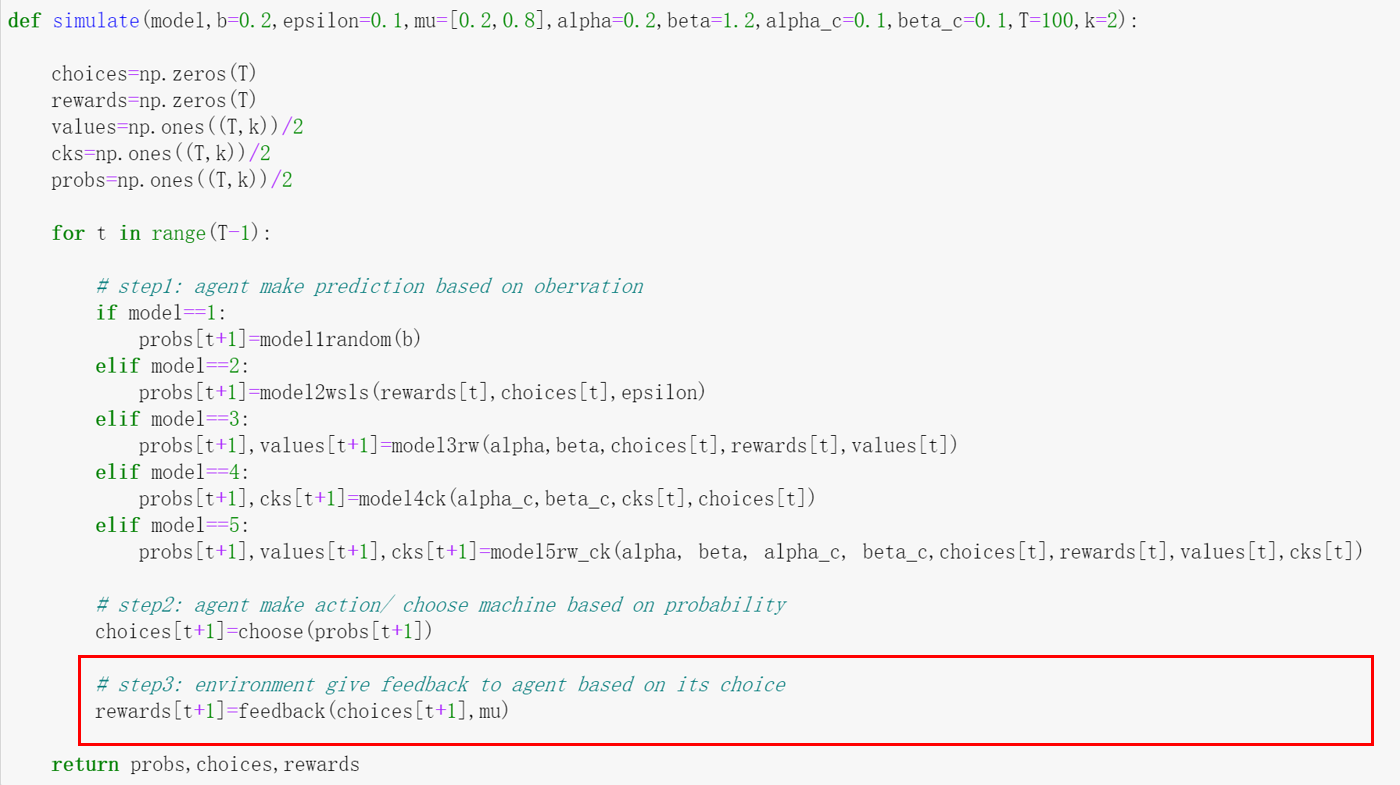

In [11]:
def feedback(choice,mu):
    # mu - machine setting: reward probability for each arm
    # machine_k give reward at the prob of mu[k-1]
    rand=np.random.uniform()
    reward = rand < mu[int(choice)]
    return reward

In [12]:
# test feedback function 
r=np.zeros(100)
c=np.zeros(100)
for i in range(100):
    r[i]=feedback(c[i],[0.2,0.8])
sum(r)

19.0

# 2. Simulate and Experiment
## ⭐Simulation tips
1. Define model-independent measures (e.g. overall performance)
2. Simulate the model across the range of parameter values like fig1.B 
3. Visualize the simulated behavior of different models like fig1.A  
<img src="fig1.png" style="zoom:80%">

#### <center>Box2-fig1</center>
<!-- ![fig1.png](attachment:fig1.png) -->

## 2.1 simulate with model1: random choice

In [40]:
# simulate(model,b=0.2,epsilon=0.1,alpha=0.2,beta=1.2,B=0.1,alpha_c=0.1,beta_c=0.1,T=100,k=2,mu=[0.2,0.8])
_,choices1,rewards1=simulate(1,b=0.5)

44.0

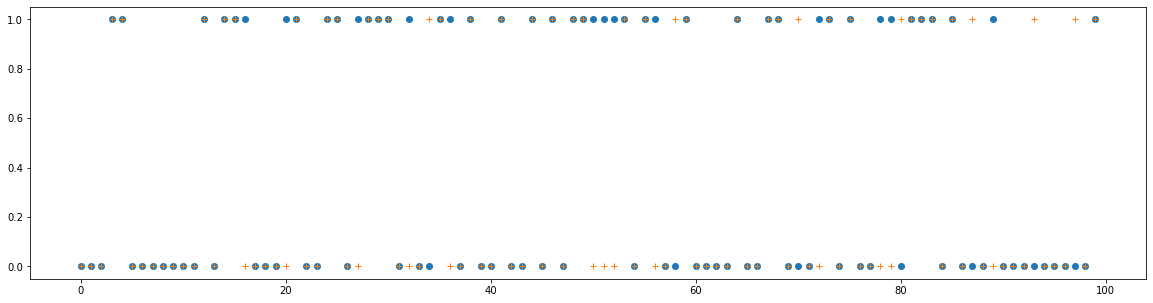

In [26]:
plt.figure(figsize= (20,5))
plt.plot(choices1,'o')
plt.plot(rewards1,'+')
sum(choices1)

## 2.2 simulate with model2: win stay lose shift

In [15]:
probs20,choices20,rewards20=simulate(2,epsilon=0)
probs21,choices21,rewards21=simulate(2,epsilon=1)
# higher epsilon, higher randomness

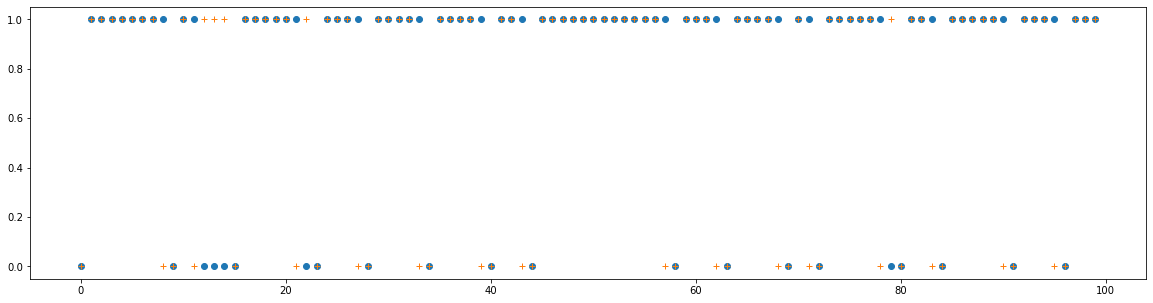

In [39]:
plt.figure(figsize= (20,5))
plt.plot(choices20,'o')
plt.plot(rewards20,'+')

## 2.3 simulate with model3: Rescorla Wagner

In [17]:
probs3,choices3,rewards3=simulate(3,alpha=0.1,beta=5)

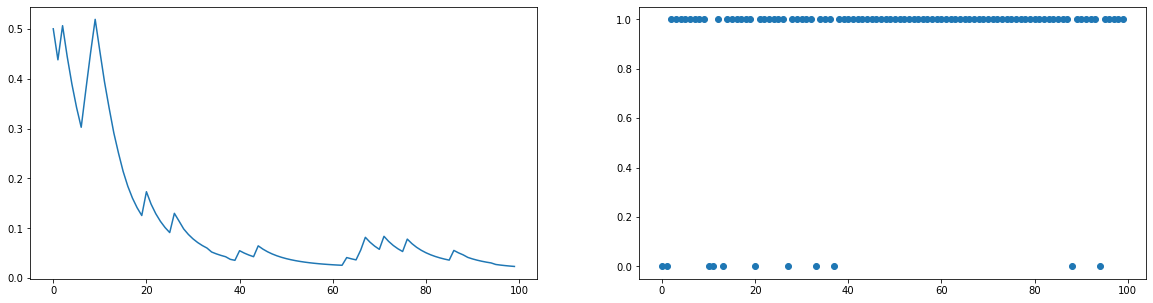

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize= (20,5))
ax1.plot(probs3[:,0])
ax2.plot(choices3,'o')

## 2.4 simulate with model4: choice kernel

In [19]:
probs4,choices4,rewards4=simulate(4,alpha_c=0.1,beta_c=3)

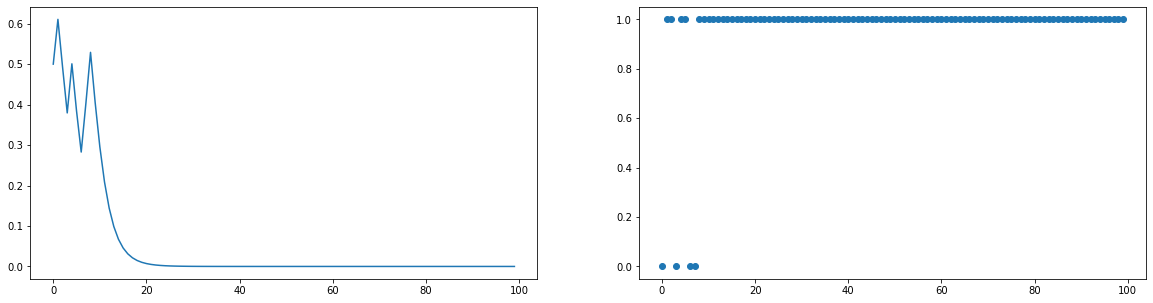

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize= (20,5))
ax1.plot(probs4[:,0])
ax2.plot(choices4,'o')

## 2.5 simulate with model5: rw+ck

In [21]:
probs5,choices5,rewards5=simulate(5,alpha=0.1,beta=5,alpha_c=0.1,beta_c=1)

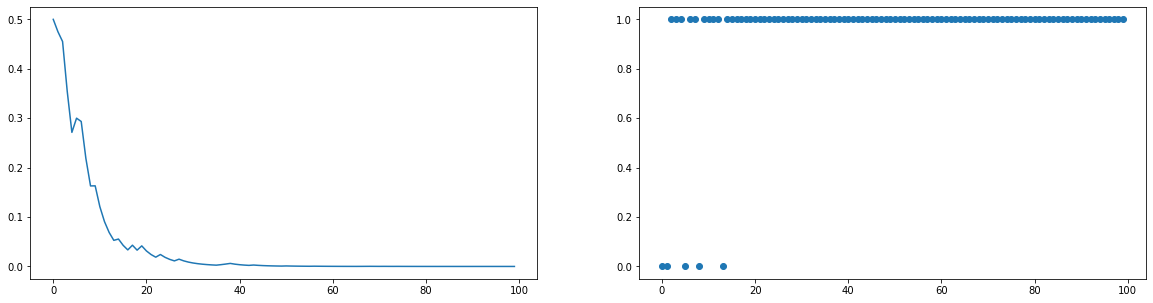

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize= (20,5))
ax1.plot(probs5[:,0])
ax2.plot(choices5,'o')

In [23]:
def stay_behavior(choices,rewards):
    T=len(choices)
    stay= np.array(choices[1:T-1]==choices[0:T-2])
    win= np.array(rewards==1)
    mask= win[0:T-2]
    p_stay_win=sum(stay[mask])/sum(mask)
    p_stay_lose=sum(stay[~mask])/sum(~mask)
    return [p_stay_lose,p_stay_win]

(Text(0.5, 0, 'previous reward'), Text(0, 0.5, 'p(stay)'))

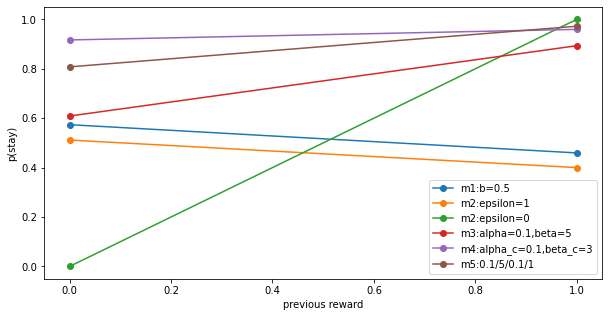

In [30]:
plt.figure(figsize= (10,5))
plt.plot([0,1],stay_behavior(choices1,rewards1),'o-'),plt.plot([0,1],stay_behavior(choices21,rewards21),'o-')
plt.plot([0,1],stay_behavior(choices20,rewards20),'o-'),plt.plot([0,1],stay_behavior(choices3,rewards3),'o-')
plt.plot([0,1],stay_behavior(choices4,rewards4),'o-'),plt.plot([0,1],stay_behavior(choices5,rewards5),'o-')
plt.legend(["m1:b=0.5","m2:epsilon=1","m2:epsilon=0","m3:alpha=0.1,beta=5","m4:alpha_c=0.1,beta_c=3","m5:0.1/5/0.1/1"])
plt.xlabel("previous reward"),plt.ylabel("p(stay)")

# 3. Fit Model(θ) to Data
1. Target: 
    - minimize cost function = f(θ)
2. Approach
    - sampling (MCMC)
    - <u>point estimate</u> (MAP/MLE) 
3. Optimization
    - brute force search
    - gradient ascent/descent
4. Tools
    - Matlab fmincon
    - Python scipy.optimize.minimize
    - R optim

$$ \hat{\Theta}=argmax L(\Theta) $$

In [31]:
# import scipy.optimize as sop
def fit_model3rw(choices,rewards):
    x0=[np.random.uniform(0,1),np.random.exponential(1)]
    result=sop.minimize(fun=likli_model3rw,x0=x0,args=(choices,rewards),
                        bounds=[(0,1),(0,10)],method='trust-constr')
    return result

In [35]:
probs3s,choices3s,rewards3s=simulate(3,alpha=0.5,beta=5)
result_fitted=fit_model3rw(choices3s,rewards3s)
print(result_fitted.success,result_fitted.x)

True [0.41357354 5.83016582]


## 3.2 Likelihood Function
$$ \small P(\Theta_m|DATA) \propto \underline{P(DATA|\Theta_m)} \times P(\Theta_m)$$
$$ \small Likelihood= \prod_{t=1}^T p(data_t|\Theta_m)$$
$$ \small LogL= \sum_{t=1}^T log p(data_t|\Theta_m)=\sum_{t=1}^T logp(choice_t|\Theta_m)$$

In [33]:
def likli_model3rw(alpha_beta,choices,rewards):
    T=len(choices)
    alpha,beta=alpha_beta
#   alpha,beta,B=alpha_beta_B
    values=np.ones((T,2))/2
    probs=np.ones((T,2))/2
    choice_probs=np.ones(T)/2
    for t in range(T-1):
        choice_probs[t]=probs[t][int(choices[t])]
        probs[t+1],values[t+1]=model3rw(alpha,beta,choices[t],rewards[t],values[t])
    neg_likli = -sum(np.log(choice_probs))
    return neg_likli

## ⭐Fitting Tips
1. Be sure that your initial conditions give finite log-likelihoods
2. Beware rounding errors, zeros and infinities
    - constraining parameter values to always give finite choice probabilities and log-likelihoods at the boundaries.
3. Be careful with constraints on parameters
    - ill chosen constraints lead to solution at the bounds
4. Beware local minima!
    - run the fitting procedure multiple times with random initial conditions, recording the best fitting log-likelihood
    - As the number of initial conditions increases, the best-fitting likelihood will improve up to an asymptote close to the true maximum of the function

# 4. Parameter Recovery
## 4.1 Why parameter recovery
--- 
<!-- ![recovery.png](attachment:recovery.png) -->
<center><img src="recovery.png" style="zoom:80%">
    
#### Box4-fig1: Parameter Recovery for Model3/ Rescorla Wagner</center>

## 4.2 How to recover parameter
###     recovery = (simulate + fit ) × multiple times + compare

In [36]:
count=200
alphas_random=np.random.uniform(0,1,count)
betas_random=np.random.exponential(3,count)
# Bs_random=np.random.uniform(0,0.2,count)

para_recovered=np.zeros((count,2))
                     
for cnt in range(count-1):
    # simluate with random parameter to get fake data
    _,choices,rewards=simulate(3,alpha=alphas_random[cnt],beta=betas_random[cnt])
    # fit fake data to get estimated parameter
    result=fit_model3rw(choices,rewards)
#     print("test:",cnt," result:",result)
    para_recovered[cnt]=result.x

<ipython-input-33-b8d515319ed6>:11: RuntimeWarning: divide by zero encountered in log
  neg_likli = -sum(np.log(choice_probs))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


## 4.3 Compare recovered parameter to true parameter

([<matplotlib.lines.Line2D at 0x2a8f7a682e0>],
 Text(0.5, 1.0, 'softmax temperature'))

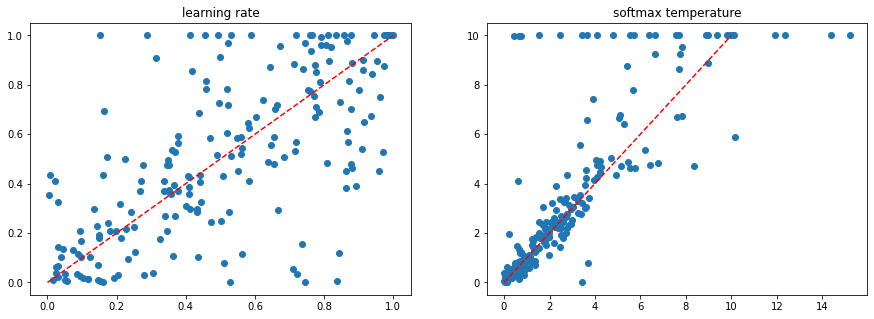

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize= (15,5))
ax1.scatter(alphas_random,para_recovered[:,0])
ax1.plot([0,1],[0,1],'r--'),ax1.set_title("learning rate")
ax2.scatter(betas_random,para_recovered[:,1])
ax2.plot([0,10],[0,10],'r--'),ax2.set_title("softmax temperature")

In [38]:
print(np.corrcoef(alphas_random,para_recovered[:,0])[0,1],
      np.corrcoef(betas_random,para_recovered[:,1])[0,1])

0.6641305513657421 0.7916182190671006


## ⭐Recovery Tips:
1. Make sure your simulation parameters are in the right range
    - fitted/ previous model/ new model
    -  it is not necessarily problematic if a model’s parameters are not recoverable in a full parameter space, as long as they are recoverable in the range that matters for real data.
2. Plot the correlations between simulated and recovered parameters
3. Make sure the recovery process does not introduce correlations between parameters
4. Remember that even successful parameter recovery represents a best case scenario!
    - the inner workings of the mind and brain — is likely much more complex than any model you could conceive

# 5. Summary

--- 
<center><img src="ten.png" style="zoom:65%">
    
####     fig1
<!-- ![ten.png](attachment:ten.png) -->
